## Making Sense Of Time Series Features

Time series features is a very important type of features in a lot of banking use cases. For example, transaction time may be related to fraud cases, e-banking log on time may be related to customer's banking behaviours etc. In this notebook, I will look at different approaches for encoding time series variables. The objective is to determine the most effective method for representing date and time in a time series.

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../..')

# Options for pandas
pd.options.display.max_columns = 20
pd.options.display.max_rows = 10


### Data: Building Energy Use

We'll work with building energy use at a 15 minute frequency. Building energy data is a useful time series because it exhibits patterns at the daily, weekly, and yearly levels. 

In [2]:
data = pd.read_csv('C:/Users/ssche/Desktop/building_8_energy_data.csv', parse_dates=['timestamp'], usecols=['timestamp', 'energy'], index_col='timestamp').sort_index()
data.head()

,energy
timestamp,
2015-05-01 04:15:00,11.754912
2015-05-01 04:15:00,11.477615
2015-05-01 04:30:00,11.740892
2015-05-01 04:45:00,14.156742
2015-05-01 04:45:00,9.213514


### Basic Time and Date Features

The first set of features we'll build are those we intuitively think of: minute, hour, dayofweek, month, dayofyear, year.

In [3]:
baseline_features = ['minute', 'hour', 'dayofweek', 'day', 'week', 'month', 'dayofyear', 'year']

for feature in baseline_features:
    data['timestamp_' + feature] = getattr(data.index, feature)

data.head()

C:\Users\ssche\AppData\Local\Temp/ipykernel_13144/3804393547.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data['timestamp_' + feature] = getattr(data.index, feature)


,energy,timestamp_minute,timestamp_hour,timestamp_dayofweek,timestamp_day,timestamp_week,timestamp_month,timestamp_dayofyear,timestamp_year
timestamp,,,,,,,,,
2015-05-01 04:15:00,11.754912,15,4,4,1,18,5,121,2015
2015-05-01 04:15:00,11.477615,15,4,4,1,18,5,121,2015
2015-05-01 04:30:00,11.740892,30,4,4,1,18,5,121,2015
2015-05-01 04:45:00,14.156742,45,4,4,1,18,5,121,2015
2015-05-01 04:45:00,9.213514,45,4,4,1,18,5,121,2015


These are pretty straightforward. We should be careful to note the day of week goes from 0 (Monday) to 6 (Sunday).

In [4]:
data.apply(lambda x: x.nunique(), axis=0)

energy                 105280
timestamp_minute            4
timestamp_hour             24
timestamp_dayofweek         7
timestamp_day              31
timestamp_week             53
timestamp_month            12
timestamp_dayofyear       366
timestamp_year              3
dtype: int64

### Fractional Features

If we want to compress these features, we can convert them into fractions of their respective interval. For example, fraction of the day, fraction of the month, fraction of the week, and fraction of the year.

In [5]:
data['frac_day'] = ((data['timestamp_minute'] / 60) + data['timestamp_hour'])  / 24

In [37]:
subset = data[(data['timestamp_month'] == 5) & (data['timestamp_day'] == 1)]
subset.shape

(286, 19)

In [6]:
data['frac_week'] = (data['frac_day'] + data['timestamp_dayofweek']) / 7

For the fractional month, we have to use the number of `days_in_month` which is an attribute of a time series in Pandas.

In [8]:
data['frac_month' ] = (data['timestamp_day'] + data['frac_day']) / data.index.days_in_month

For the fraction of the year, we have to find the number of days in the year which obeys the rules:

1. 365 in a non-leap year
2. 366 in a leap year which occurs:
    * When the year is divisible by 4 except:
        * Years divisible by 100 and not divisible by 400
        
This logic is captured below

In [9]:
def find_days_in_year(years):
    return np.where((years % 4 == 0) & ((years % 100 != 0) | (years % 400 == 0)), 366, 365)


find_days_in_year(np.array([1900, 2000, 2004, 2005, 2009, 2010, 3000, 3200]))

array([365, 366, 366, 365, 365, 365, 365, 366])

In [10]:
days_in_year = find_days_in_year(data['timestamp_year'])
np.unique(days_in_year)

array([365, 366])

In [ ]:
data['frac_year'] = (data['timestamp_dayofyear'] + data['frac_day']) / days_in_year

### Cyclical Encoding of Features

Cyclical encoding of time-series features is typically done with time/date features that repeat periodically such as the hour of the day or day of the year. My experience is that cyclical encoding will improve the performance of the simple model like Linear Regression, but will not improve the performance of the model with higher capacity like the Random Forest Regression.These models are able to learn the relationships between the day of year, time of day and the target without cyclical encoding. The feature transformation does not hurt the more complex models, but it adds unnecessary steps to a machine learning pipeline without adding benefits.

#### Transformers
To repeatedly create the same features, we'll make two scikit-learn transformers and then join them together in a pipeline.

Scikit-Learn transformers give us a standard interface for applying operations to our data. Using transformers is efficient and allows you to build robust systems.


In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class DateTimeFeatures(BaseEstimator, TransformerMixin):
    """
    Extract day of year and time of day features from a timestamp
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Timestamps must be in index
        field = X.index
        X["time_of_day"] = field.hour + field.minute / 60
        X["day_of_year"] = field.dayofyear
        return X


class CyclicalDateTimeFeatures(BaseEstimator, TransformerMixin):
    """
    Make cyclically encoded day of year and time of day features
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Apply formula for sin and cosine
        X["sin_time_of_day"], X["cos_time_of_day"] = _cyclical_encoding(
            X["time_of_day"], period=24
        )
        X["sin_day_of_year"], X["cos_day_of_year"] = _cyclical_encoding(
            X["day_of_year"], period=366
        )
        return X

def _cyclical_encoding(series, period):
    """
    Cyclical encoding of a series with a specified period
    """
    # Basic formula for sin/cosine equation
    base = 2 * np.pi * series / period
    return np.sin(base), np.cos(base)

#### Pipeline

The pipeline is one of the most important features in sklearn. I highly recommend reading up on the Pipeline and using it throughout your data science projects.

In [14]:
from sklearn.pipeline import Pipeline

# Make a pipeline with the steps
transforms = Pipeline(
    steps=[
        # Must create the date/time features before encoding
        ("date_time_features", DateTimeFeatures()),
        ("cylical_date_time_features", CyclicalDateTimeFeatures()),
    ]
)

In [15]:
transformed_data = transforms.transform(data)
transformed_data.head()

,energy,timestamp_minute,timestamp_hour,timestamp_dayofweek,timestamp_day,timestamp_week,timestamp_month,timestamp_dayofyear,timestamp_year,frac_day,frac_week,frac_month,frac_year,time_of_day,day_of_year,sin_time_of_day,cos_time_of_day,sin_day_of_year,cos_day_of_year
timestamp,,,,,,,,,,,,,,,,,,,
2015-05-01 04:15:00,11.754912,15,4,4,1,18,5,121,2015,0.177083,0.596726,0.037970,0.331992,4.25,121,0.896873,0.442289,0.874481,-0.48506
2015-05-01 04:15:00,11.477615,15,4,4,1,18,5,121,2015,0.177083,0.596726,0.037970,0.331992,4.25,121,0.896873,0.442289,0.874481,-0.48506
2015-05-01 04:30:00,11.740892,30,4,4,1,18,5,121,2015,0.187500,0.598214,0.038306,0.332021,4.50,121,0.923880,0.382683,0.874481,-0.48506
2015-05-01 04:45:00,14.156742,45,4,4,1,18,5,121,2015,0.197917,0.599702,0.038642,0.332049,4.75,121,0.946930,0.321439,0.874481,-0.48506
2015-05-01 04:45:00,9.213514,45,4,4,1,18,5,121,2015,0.197917,0.599702,0.038642,0.332049,4.75,121,0.946930,0.321439,0.874481,-0.48506


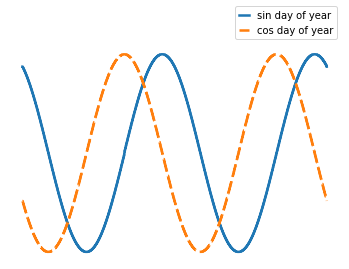

In [70]:
plt.rc('lines', linewidth=2.5)
fig, ax = plt.subplots()
y = data["sin_day_of_year"]
line1, = ax.plot( y, label='sin day of year')
line1.set_dash_capstyle('round')
y = data['cos_day_of_year']
line2, = ax.plot( y , dashes=[6, 2], label='cos day of year')
ax.legend(handlelength=1, loc='lower right', bbox_to_anchor=(1, 1))
plt.axis('off')
plt.show()


#### Final remark
We can apply different amplitude, frequency and phase or even different combination of sin and cos function to mimic different periodic pattern.